## Data Loading

In [1]:
# import os
# from PIL import Image, ImageOps
# from tqdm import tqdm  # ✅ Added progress bar

# # Source and destination directories
# src_root = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset"
# dst_root = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset_512_512"

# # Target size
# target_size = (512, 512)

# # Helper function: resize with padding (aspect-ratio preserved)
# def resize_with_padding(img, target_size, is_mask=False):
#     if is_mask and img.mode != "L":
#         img = img.convert("L")
#     elif not is_mask and img.mode != "RGB":
#         img = img.convert("RGB")

#     img = ImageOps.pad(
#         img,
#         target_size,
#         method=Image.NEAREST if is_mask else Image.BILINEAR,
#         color=0,
#         centering=(0.5, 0.5)
#     )
#     return img

# # Process all splits
# splits = ["train", "val", "test"]
# for split in splits:
#     for subfolder in ["images", "masks"]:
#         src_dir = os.path.join(src_root, split, subfolder)
#         dst_dir = os.path.join(dst_root, split, subfolder)
#         os.makedirs(dst_dir, exist_ok=True)

#         file_list = [
#             f for f in os.listdir(src_dir)
#             if f.lower().endswith((".png", ".jpg", ".jpeg"))
#         ]

#         print(f"🔄 Processing {split}/{subfolder} ({len(file_list)} files)...")
#         for fname in tqdm(file_list, desc=f"{split}/{subfolder}"):
#             src_path = os.path.join(src_dir, fname)
#             dst_path = os.path.join(dst_dir, fname)

#             with Image.open(src_path) as img:
#                 resized = resize_with_padding(img, target_size, is_mask=(subfolder == "masks"))
#                 resized.save(dst_path)

# print("✅ All images and masks resized to 512x512 with padding. Saved to:", dst_root)

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import torch
from torchvision import transforms

class SegformerSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=512):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.filenames = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0,1] float32
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_name)[0] + ".png")

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Convert mask to label ids
        mask = np.array(mask, dtype=np.uint8)
        mask = np.where(mask == 255, 2, np.where(mask == 127, 1, 0))

        image = self.img_transform(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

In [3]:
# Root path to resized dataset
base_path = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset_512_512"

# Datasets
train_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "train", "images"),
    mask_dir=os.path.join(base_path, "train", "masks"),
)

val_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "val", "images"),
    mask_dir=os.path.join(base_path, "val", "masks"),
)

test_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "test", "images"),
    mask_dir=os.path.join(base_path, "test", "masks"),
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

## Training

In [4]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig
import torch

NUM_CLASSES = 3

# Load SegFormer-B2 configuration and model
config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label={0: "background", 1: "crack", 2: "pothole"},
    label2id={"background": 0, "crack": 1, "pothole": 2}
)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    config=config,
    ignore_mismatched_sizes=True,
    use_safetensors=True  
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch.nn as nn
import torch.optim as optim

# ⚖️ Class weights for handling imbalance: [background, crack, pothole]
class_weights = torch.tensor([0.1, 2.0, 1.5]).to(device)

# 🔥 Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 🚀 Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=10,
    save_path="segformer_b2_best_model.pth",
    last_model_path="segformer_b2_last_model.pth",
    checkpoint_path="segformer_b2_checkpoint.pth",
    pause_file="pause.flag"
):
    start_epoch = 0
    best_miou = -1.0
    miou_list = []
    dice_list = []

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("🔁 Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_miou = checkpoint.get('best_miou', -1.0)
        print(f"➡️ Resumed from epoch {start_epoch}, Best mIoU so far: {best_miou:.4f}")

    model.to(device)
    print(f"📟 Using device: {device}")

    for epoch in range(start_epoch, num_epochs):
        while os.path.exists(pause_file):
            print("⏸️ Training paused. Remove 'pause.flag' to resume.")
            time.sleep(5)

        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            import torch.nn.functional as F
            logits = F.interpolate(outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"\n📘 Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

        val_loss, miou, dice, ious, dices = validate(model, val_loader, criterion)

        miou_list.append(miou)
        dice_list.append(dice)

        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved! mIoU = {best_miou:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_miou': best_miou
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")

    torch.save(model.state_dict(), last_model_path)
    print(f"📦 Final model saved to: {last_model_path}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(miou_list, label="mIoU", marker='o')
    plt.plot(dice_list, label="Dice", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("mIoU and Dice over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_metrics.png")
    plt.show()

    with open("metrics_log.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "mIoU", "Dice"])
        for epoch, (m, d) in enumerate(zip(miou_list, dice_list), start=1):
            writer.writerow([epoch, m, d])

def compute_iou_and_dice(preds, labels, num_classes=3):
    preds = preds.flatten()
    labels = labels.flatten()
    cm = confusion_matrix(labels, preds, labels=range(num_classes))

    ious, dices = [], []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom_iou = tp + fp + fn
        denom_dice = 2 * tp + fp + fn

        iou = tp / denom_iou if denom_iou > 0 else 0
        dice = (2 * tp) / denom_dice if denom_dice > 0 else 0

        ious.append(iou)
        dices.append(dice)

    return ious, dices, np.mean(ious), np.mean(dices)

@torch.no_grad()
def validate(model, val_loader, criterion, num_classes=3):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    for images, masks in tqdm(val_loader, desc="🔍 Validating", leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(pixel_values=images)
        logits = F.interpolate(outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        loss = criterion(logits, masks)
        val_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(masks.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    ious, dices, miou, mdice = compute_iou_and_dice(all_preds, all_labels, num_classes=num_classes)

    print(f"🔎 Val Loss: {avg_val_loss:.4f}, mIoU: {miou:.4f}, Dice: {mdice:.4f}")
    for idx, (iou, dice) in enumerate(zip(ious, dices)):
        print(f"🧾 Class {idx}: IoU = {iou:.4f}, Dice = {dice:.4f}")

    return avg_val_loss, miou, mdice, ious, dices

## Start Training

In [7]:
# model.load_state_dict(torch.load("segformer_B2_best.pth"))

In [ ]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=60,
    save_path="segformer_B2_best.pth",
    last_model_path="segformer_B2_last.pth",
    checkpoint_path="segformer_B2_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_11824\1897298777.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

➡️ Resumed from epoch 25, Best mIoU so far: 0.6210
📟 Using device: cuda



📘 Epoch 26: Avg Train Loss = 0.0661


🔎 Val Loss: 2.0328, mIoU: 0.3319, Dice: 0.3345
🧾 Class 0: IoU = 0.9919, Dice = 0.9960
🧾 Class 1: IoU = 0.0038, Dice = 0.0075
🧾 Class 2: IoU = 0.0000, Dice = 0.0000
💾 Checkpoint saved at epoch 26



📘 Epoch 27: Avg Train Loss = 0.0618


🔎 Val Loss: 9.5150, mIoU: 0.3306, Dice: 0.3320
🧾 Class 0: IoU = 0.9919, Dice = 0.9959
🧾 Class 1: IoU = 0.0000, Dice = 0.0000
🧾 Class 2: IoU = 0.0000, Dice = 0.0000
💾 Checkpoint saved at epoch 27



📘 Epoch 28: Avg Train Loss = 0.0686


🔎 Val Loss: 18.5702, mIoU: 0.3306, Dice: 0.3320
🧾 Class 0: IoU = 0.9919, Dice = 0.9959
🧾 Class 1: IoU = 0.0000, Dice = 0.0000
🧾 Class 2: IoU = 0.0000, Dice = 0.0000
💾 Checkpoint saved at epoch 28



📘 Epoch 29: Avg Train Loss = 0.0642


🔎 Val Loss: 32.1128, mIoU: 0.3306, Dice: 0.3320
🧾 Class 0: IoU = 0.9919, Dice = 0.9959
🧾 Class 1: IoU = 0.0000, Dice = 0.0000
🧾 Class 2: IoU = 0.0000, Dice = 0.0000
💾 Checkpoint saved at epoch 29



📘 Epoch 30: Avg Train Loss = 0.0645


🔎 Val Loss: 27.6333, mIoU: 0.3306, Dice: 0.3320
🧾 Class 0: IoU = 0.9919, Dice = 0.9959
🧾 Class 1: IoU = 0.0000, Dice = 0.0000
🧾 Class 2: IoU = 0.0000, Dice = 0.0000
💾 Checkpoint saved at epoch 30


Epoch [31/60] Training:   0%|▏                                          | 1/224 [00:24<1:32:51, 24.98s/it, loss=0.0751]

## To be updated

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_confusion_metrics(preds, labels, num_classes=3):
    """
    preds and labels must be 1D arrays of class IDs.
    """
    cm = confusion_matrix(labels, preds, labels=range(num_classes))
    print("🔷 Confusion Matrix:")
    print(cm)

    per_class_accuracy = {}
    for cls in range(num_classes):
        tp = cm[cls, cls]
        total = cm[cls, :].sum()
        acc = tp / total if total > 0 else 0.0
        per_class_accuracy[cls] = acc

    return cm, per_class_accuracy

In [8]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(pixel_values=images)
            logits = torch.nn.functional.interpolate(
                outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            )
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    # Standardized Confusion Matrix (Row-normalized)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    # Plot confusion matrix (standardized)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix")
    plt.tight_layout()
    plt.show()

C:\Users\SHREY\AppData\Local\Temp\ipykernel_19912\4138738451.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("segformer_B2_best.pth", ma


📊 Performance Metrics:
Pixel Accuracy: 0.9845
Per-class Accuracy:
  Background: 0.9863
  Crack: 0.7481
  Pothole: 0.7992
IoU per class:
  Background: 0.9845
  Crack: 0.2247
  Pothole: 0.6477
Mean IoU: 0.6189

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9863  0.0130  0.0006
Crack     : 0.2477  0.7481  0.0042
Pothole   : 0.1679  0.0329  0.7992


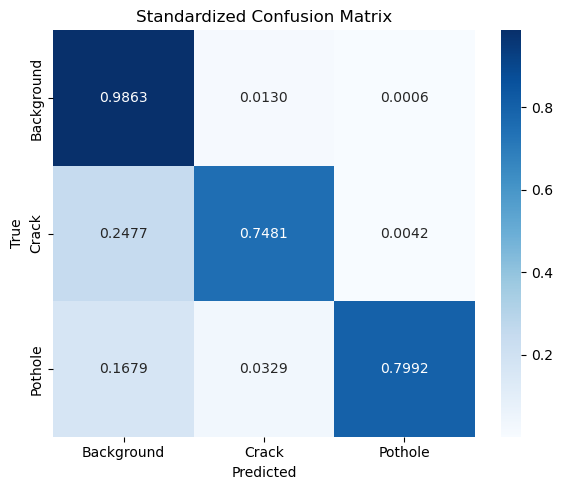

In [9]:
model.load_state_dict(torch.load("segformer_B2_best.pth", map_location=device))
model.to(device)
compute_metrics(model, test_loader, device)